In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
%matplotlib inline
pd.options.mode.chained_assignment = None

# Get and process actual MRT network

In [2]:
stations = pd.read_csv('stations.csv')
stations.drop(['mrt_station_chinese', 'mrt_line_chinese'], axis=1, inplace=True)
stations.columns = ['stn_code', 'mrt_station', 'mrt_line']
def get_stn_code(x):
    if x not in ['STC', 'PTC']:
        return int(x[2:])
    else:
        return 0
stations['stn_no'] = stations.stn_code.apply(get_stn_code)
stations.head()

,stn_code,mrt_station,mrt_line,stn_no
0,NS1,Jurong East,North South Line,1
1,NS2,Bukit Batok,North South Line,2
2,NS3,Bukit Gombak,North South Line,3
3,NS4,Choa Chu Kang,North South Line,4
4,NS5,Yew Tee,North South Line,5


# Process MRT trips

In [3]:
trips = pd.read_csv('mrt_trips_sampled.csv', index_col='index')
# remove things like NSEW or CCL at the end
import re
regex = r"(\s[A-Z]{2}[A-Z]*)"
pattern = re.compile(regex)
def strip_line_name(x):
    matches = pattern.findall(x)
    if not matches:
        return x.strip()
    else:
        return x.replace(matches[0], '').strip()

trips.destination = trips.destination.apply(strip_line_name)
trips.origin = trips.origin.apply(strip_line_name)
trips['destination_tm'] = pd.to_datetime(trips.destination_tm, format='%H:%M:%S')
trips['origin_tm'] = pd.to_datetime(trips.origin_tm, format='%H:%M:%S')
trips = trips[trips.origin != trips.destination]
trips.head()

,destination,destination_tm,origin,origin_tm
index,,,,
0,Bugis,1900-01-01 10:04:47,Stevens,1900-01-01 09:52:23
1,Kent Ridge,1900-01-01 10:11:34,Sengkang,1900-01-01 09:27:41
2,Tai Seng,1900-01-01 09:35:59,Compassvale,1900-01-01 09:03:44
3,Labrador Park,1900-01-01 09:45:50,Bishan,1900-01-01 09:14:45
4,Joo Koon,1900-01-01 09:27:32,Boon Lay,1900-01-01 09:20:36


In [4]:
# dictionary mapping line and station name to number
station2info = defaultdict(dict)
for i, row in stations.iterrows():
    station2info[row.mrt_station][row.mrt_line] = row.stn_no

In [5]:
# add mrt_line information to each trip
def get_mrt_lines(x):
    lines_origin = set(station2info[x.origin].keys())
    lines_dest = set(station2info[x.destination].keys())
    intersecting = lines_origin.intersection(lines_dest)
    return list(intersecting)[0] if intersecting else ''

trips['mrt_lines'] = trips.apply(get_mrt_lines, axis=1)
trips.head()

,destination,destination_tm,origin,origin_tm,mrt_lines
index,,,,,
0,Bugis,1900-01-01 10:04:47,Stevens,1900-01-01 09:52:23,Downtown Line
1,Kent Ridge,1900-01-01 10:11:34,Sengkang,1900-01-01 09:27:41,
2,Tai Seng,1900-01-01 09:35:59,Compassvale,1900-01-01 09:03:44,
3,Labrador Park,1900-01-01 09:45:50,Bishan,1900-01-01 09:14:45,Circle Line
4,Joo Koon,1900-01-01 09:27:32,Boon Lay,1900-01-01 09:20:36,East West Line


In [6]:
trips.mrt_lines.unique()

array(['Downtown Line', '', 'Circle Line', 'East West Line',
       'North South Line', 'Bukit Panjang LRT', 'North East Line',
       'Punggol LRT', 'Sengkang LRT', 'Changi Airport Branch Line',
       'Circle Line Extension'], dtype=object)

In [7]:
def get_direction(start_stn, end_stn):
    if end_stn > start_stn:
        return 1
    else:
        return -1

trips = trips[trips.mrt_lines != '']
trips['origin_stn_no'] = trips.apply(lambda x: station2info[x.origin][x.mrt_lines], axis=1)
trips['destination_stn_no'] = trips.apply(lambda x: station2info[x.destination][x.mrt_lines], axis=1)
trips['direction'] = trips.apply(lambda x: get_direction(x.origin_stn_no, x.destination_stn_no), axis=1)
trips.head()

,destination,destination_tm,origin,origin_tm,mrt_lines,origin_stn_no,destination_stn_no,direction
index,,,,,,,,
0,Bugis,1900-01-01 10:04:47,Stevens,1900-01-01 09:52:23,Downtown Line,10,14,1
3,Labrador Park,1900-01-01 09:45:50,Bishan,1900-01-01 09:14:45,Circle Line,15,27,1
4,Joo Koon,1900-01-01 09:27:32,Boon Lay,1900-01-01 09:20:36,East West Line,27,29,1
5,Choa Chu Kang,1900-01-01 09:48:40,Khatib,1900-01-01 09:19:25,North South Line,14,4,-1
6,Sembawang,1900-01-01 09:11:07,Woodlands,1900-01-01 09:01:48,North South Line,9,11,1


# Construct dictionary of how many people are at each stop at a given time

In [8]:
# WARNING: this cell takes about 5 minues to run
from datetime import datetime, timedelta
import pickle as pk


from datetime import datetime, timedelta
import pickle as pk

# make a nested dict 3 levels deep that ends in int
def make_nested_dict():
    return defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# round to nearest minute
def round_time(dt):
    return dt.replace(second=0, microsecond=0)

infodict = make_nested_dict()
infodict_reversed_dir = make_nested_dict()

for index, row in trips.iterrows():
    small, big = sorted([row.origin_stn_no, row.destination_stn_no])
    if big == small:
        continue
    time_delta = (row.destination_tm - row.origin_tm).total_seconds()
    # assume every stop took the same amount of time
    time_between_stop = time_delta / (big - small)
    
    for stop in range(small, big+1):
        seconds_travelled = time_between_stop * (stop - small)
        time_at_stop = row.origin_tm + timedelta(seconds=seconds_travelled)
        if row.direction == 1:
            infodict[row.mrt_lines][stop][round_time(time_at_stop)] += 1
        else:
            infodict_reversed_dir[row.mrt_lines][stop][round_time(time_at_stop)] += 1

In [9]:
# this is the function that gets the number of people on the train, returns a dataframe
# which is easier to look at because dictionary is not ordered
TIME_BTWN_STOPS = 2*60
def people_on_train(start, end, start_time):
    if isinstance(start_time, str):
        start_time = datetime.strptime(start_time, '%H:%M')
    start_stn_lines = set(station2info[start].keys())
    end_stn_lines = set(station2info[end].keys())
    lines = list(start_stn_lines.intersection(end_stn_lines))
    if not lines:
        raise ValueError('Two stations must be on the same line.')
    line = lines[0]
    start_stn_no = station2info[start][line]
    end_stn_no = station2info[end][line]
    direction = get_direction(start_stn_no, end_stn_no)
    if direction == 1:
        relevant_dict = infodict
    else:
        relevant_dict = infodict_reversed_dir

    # find overlap
    num_people = defaultdict(int)
    temp = sorted([start_stn_no, end_stn_no])
    stations_passed = range(temp[0], temp[1]+1)
    for stop in stations_passed:
        seconds_travelled = TIME_BTWN_STOPS * abs(stop - start_stn_no)
        time_at_stop = start_time + timedelta(seconds=seconds_travelled)
        rounded_time = round_time(time_at_stop)
        times = [rounded_time]
        for i in range(1, 2):
            times.append(rounded_time + timedelta(minutes=i))
        
        people = 0
        for t in times:
            people += relevant_dict[line][stop][t]
        num_people[stop] = people
    
    # convert station numbers to names
    passed_stations = stations[(stations.mrt_line == line) & (stations.stn_no >= min(start_stn_no, end_stn_no)) & (stations.stn_no <= max(start_stn_no, end_stn_no))]
    passed_stations['num_people'] = passed_stations.stn_no.map(num_people)
    passed_stations.drop(['stn_no', 'mrt_line', 'stn_code'], axis=1, inplace=True)
    if direction == -1:
        passed_stations = passed_stations.iloc[::-1]
    passed_stations.reset_index(drop=True, inplace=True)
    passed_stations.plot(kind='bar', x='mrt_station')
    return passed_stations

# Examples

,mrt_station,num_people
0,Clementi,111
1,Dover,90
2,Buona Vista,120
3,Commonwealth,141
4,Queenstown,360
5,Redhill,510
6,Tiong Bahru,630
7,Outram Park,753
8,Tanjong Pagar,618
9,Raffles Place,531


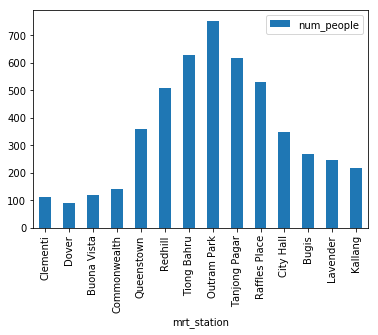

In [10]:
people_on_train('Clementi', 'Kallang', '9:05')

,mrt_station,num_people
0,Clementi,111
1,Dover,90


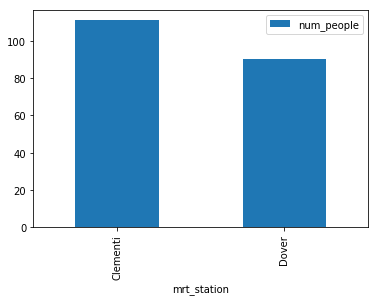

In [11]:
people_on_train('Clementi', 'Dover', '9:05')